# Модуль загрузки данных

In [57]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor, KNNBasic

# from sklearn.model_selection import train_test_split

plt.style.use('fast')
%matplotlib inline

In [58]:
pd.set_option('display.max_columns', 50)

читаем данные `out` из `FinalDataPreparation`

In [59]:
transactions = pd.read_csv('Data/out.zip')
transactions.head(3)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1


In [60]:
transactions.shape

(671674, 8)

In [61]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

In [62]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

описание данных:

- t_dat : дата покупки
- customer_id : id клиента
- article_id : id товара в articles таблице
- price : Стоимость покупки
- sales_channel_id : 1 or 2

### Обработка данных 

In [63]:
# конвертируем в класс Reader из sct learn и згаружаем данные
reader = Reader(rating_scale = (0,1))
customer_data = Dataset.load_from_df(transactions[['customer_id', 'article_id', 'bought']], reader)

In [64]:
type(customer_data)

surprise.dataset.DatasetAutoFolds

In [65]:
# разбиваем данные для рекомендательной модели
trainset, testset = train_test_split(customer_data, test_size=0.2, random_state=42)

In [66]:
# Вывод информации для обучабщего набора
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  172712 

Number of items:  9225 



## Создание модели

### Базлайны без крос валидации

In [67]:
# создание базлайнов
baseline = NormalPredictor()
baseline.fit(trainset)

# тестовые предсказания для fit
predictions = baseline.test(testset)

# RMSE
baseline_normal = accuracy.rmse(predictions)

RMSE: 0.0000


In [68]:
# Создание и настройка модели
baseline2 = BaselineOnly()
baseline2.fit(trainset)

predictions = baseline2.test(testset)

# RMSE
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.0000


### SVD модель

In [69]:
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
svd_simple_predictions = accuracy.rmse(svd_predictions)
svd_simple_predictions

RMSE: 0.0461


0.04613940369951133

In [70]:
svd_model.predict('0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', 902802002)

Prediction(uid='0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', iid=902802002, r_ui=None, est=1, details={'was_impossible': False})

In [71]:
transactions.loc[(transactions['customer_id'] == '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2') & 
                 (transactions['article_id'] == 902802002)]

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought


In [72]:
param_grid = {'n_factors':[10,50],'n_epochs': [5, 15], 'lr_all': [0.002,0.01],
             'reg_all': [0.2,0.6]}
gs_model_SVD1 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD1.fit(customer_data)

gs_model_SVD1.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   56.0s finished


{'rmse': {'n_factors': 10, 'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.6}}

In [73]:
param_grid2 = {'n_factors':[5,10],'n_epochs': [15, 50], 'lr_all': [0.001, 0.01],
             'reg_all': [0.6, 0.8]}
gs_model_SVD2 = GridSearchCV(SVD,param_grid=param_grid2,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD2.fit(customer_data)

gs_model_SVD2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:   57.1s finished


{'rmse': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.8}}

In [74]:
param_grid3 = {'n_factors':[10],'n_epochs': [50, 100], 'lr_all': [0.1, 0.2],
             'reg_all': [0.8, 0.9]}
gs_model_SVD3 = GridSearchCV(SVD,param_grid=param_grid3,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD3.fit(customer_data)

gs_model_SVD3.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-2)]: Done  36 out of  40 | elapsed:   41.3s remaining:    4.6s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   44.5s finished


{'rmse': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.2, 'reg_all': 0.8}}

In [75]:
param_grid4 = {'n_factors':[10],'n_epochs': [100, 150], 'lr_all': [0.2, 0.3],
             'reg_all': [0.7, 0.8]}
gs_model_SVD4 = GridSearchCV(SVD,param_grid=param_grid4,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD4.fit(customer_data)

gs_model_SVD4.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  36 out of  40 | elapsed:   47.3s remaining:    5.3s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   50.7s finished


{'rmse': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.3, 'reg_all': 0.7}}

Лучшие параметры для SVD модели - 
- n_factors : 10
- n_epochs : 100
- lr_all :0.2
- reg_all : 0.8

Построим модель и протестируем на тестовых данных

In [76]:
svd_model2 = SVD(n_factors= 10, n_epochs= 50)
svd_model2.fit(trainset)
svd_predictions2 = svd_model2.test(testset)
svd_tuned_predictions = accuracy.rmse(svd_predictions2)
svd_tuned_predictions

RMSE: 0.0115


0.011463237187893525

### NFM модель

разница с предыдущим методом заключается в том, что в NMF для процесса стохастического градиентного спуска регуляризации задается определенный размер шага. Это делается для того, чтобы все факторы пользователя и предмета оставались положительными. Хотя эта модель может быть склонна к чрезмерной подгонке параметров, это можно смягчить с помощью шагов по уменьшению размерности наших данных/факторов.

In [77]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)
nmf_simple_predictions = accuracy.rmse(nmf_predictions)
nmf_simple_predictions

RMSE: 0.0677


0.06767327849384087

In [78]:
param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
gs_model_NFM = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM.fit(customer_data)

gs_model_NFM.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-2)]: Done  42 out of  45 | elapsed:  1.3min remaining:    5.6s
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:  1.4min finished


{'rmse': {'n_factors': 10, 'n_epochs': 75}}

In [79]:
param_grid = {'n_factors':[10],'n_epochs': [75, 100]}
gs_model_NFM2 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM2.fit(customer_data)

gs_model_NFM2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  10 | elapsed:   14.9s remaining:   34.7s
[Parallel(n_jobs=-2)]: Done   6 out of  10 | elapsed:   19.6s remaining:   13.0s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:   28.0s finished


{'rmse': {'n_factors': 10, 'n_epochs': 100}}

Лучшие параметры для NMF модели - 
- n_factors : 10
- n_epochs : 100

Протестируем лучшие параметры на тестовых данных

In [80]:
nmf_model2 = NMF(n_factors = 10, n_epochs = 100)
nmf_model2.fit(trainset)
nmf_predictions2 = nmf_model2.test(testset)
nmf_tuned_predictions = accuracy.rmse(nmf_predictions2)

pickle.dump(nmf_model2, open('Model/collaborative_model_NMF.sav', 'wb'))

nmf_tuned_predictions

RMSE: 0.0583


0.05825967337192565

## SVD ++ модель

Разница модели SVD с SVD++ заключается в том, что SVD++ пытается добавить расширение к базовому SVD, которое использует неявный рейтинг, а также явный. Другими словами, он учитывает действие по оценке предмета как латентный фактор, независимо от значения рейтинга, присвоенного предмету, а также факторизует фактическое значение рейтинга

In [81]:
# создание модели
SVDpp_model = SVDpp()
SVDpp_model.fit(trainset)
SVDpp_predictions = SVDpp_model.test(testset)
svdpp_simple_predictions = accuracy.rmse(SVDpp_predictions)

svdpp_simple_predictions

RMSE: 0.0208


0.02082139853862302

In [82]:
# словарь для SVD++
svdpp_param_grid = {'n_factors':[1, 5], 'n_epochs':[25, 50], 'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Подбор и возврат наилучших_параметров на основе перекрестной валидации, данный подбор занимает много времени
svdpp_gs_model.fit(customer_data)

svdpp_gs_model.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  16 out of  24 | elapsed:   18.3s remaining:    9.2s
[Parallel(n_jobs=-2)]: Done  21 out of  24 | elapsed:   22.8s remaining:    3.3s
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed:   25.9s finished


{'rmse': {'n_factors': 1, 'n_epochs': 50, 'reg_all': 0.05}}

In [83]:
# словарь для SVD++
svdpp_param_grid2 = {'n_factors':[1], 'n_epochs':[50, 100], 'reg_all':[0.05, 0.1]}
svdpp_gs_model2 = GridSearchCV(SVDpp, param_grid=svdpp_param_grid2, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

svdpp_gs_model2.fit(customer_data)

svdpp_gs_model2.best_params

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  12 | elapsed:    7.1s remaining:   35.4s
[Parallel(n_jobs=-2)]: Done   5 out of  12 | elapsed:    9.2s remaining:   12.8s
[Parallel(n_jobs=-2)]: Done   8 out of  12 | elapsed:   16.5s remaining:    8.2s
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:   19.1s finished


{'rmse': {'n_factors': 1, 'n_epochs': 100, 'reg_all': 0.1}}

лучшие параметры для SVD ++ моедли - 
- n_factors : 1
- n_epochs : 100
- reg_all : 0.1

Протестируем лучшие параметры на тестовых данных

In [84]:
# тест
SVDpp_model2 = SVDpp(n_factors=1, n_epochs=100, reg_all=0.1)
SVDpp_model2.fit(trainset)
SVDpp_predictions2 = SVDpp_model2.test(testset)
svdpp_tuned_predictions = accuracy.rmse(SVDpp_predictions2)

pickle.dump(nmf_model2, open('Model/collaborative_model_svdpp.sav', 'wb'))
svdpp_tuned_predictions

RMSE: 0.0008


0.000847912933913345

## Производительность модели

In [85]:
baseline_only = 0.00
svd_simple_predictions = 0.0463
svd_tuned_predictions = 0.0115
nmf_simple_predictions = 0.0676
nmf_tuned_predictions = 0.0582
svdpp_simple_predictions = 0.0206
svdpp_tuned_predictions = 0.0207

In [86]:
X = ['Baseline', 'SVD Basic', 'SVD Tuned', 'NMF Basic', 'NMF tuned', 'SVD ++ Basic', 'SVD ++ Tuned']
y = [baseline_only, svd_simple_predictions, svd_tuned_predictions, nmf_simple_predictions, nmf_tuned_predictions, svdpp_simple_predictions, svdpp_tuned_predictions]

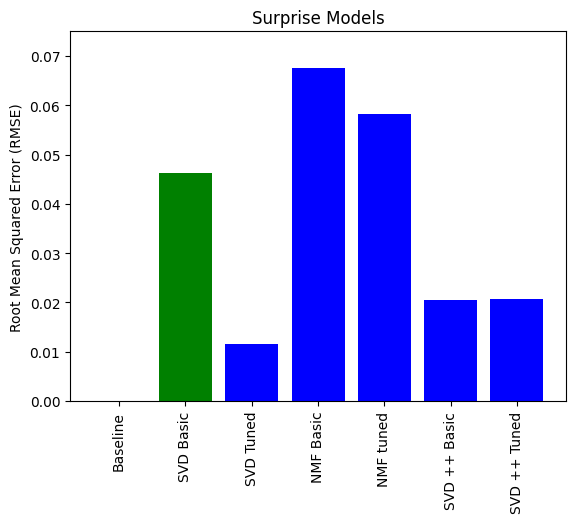

In [87]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'green', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(rotation=90)
plt.ylim(0, .075)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/Model_bar.png', dpi=500, bbox_inches='tight');

# Функция рекомендаций

### сборка

##### финальная модель

In [88]:
trainset_full = customer_data.build_full_trainset()

In [89]:
final_model = SVD(n_factors= 10, n_epochs= 50)
final_model.fit(trainset_full)

In [90]:
pickle.dump(final_model, open('Model/collaborative_model_svd.sav', 'wb'))

In [91]:
collab_model = pickle.load(open('Model/collaborative_model_svd.sav', 'rb'))

In [92]:
transactions.tail(10)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
671664,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,651591001,0.032186,2,2020-09-22,2020-09-22,1
671665,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,864339003,0.022017,2,2020-09-22,2020-09-22,1
671666,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,938667001,0.010153,2,2020-09-22,2020-09-22,1
671667,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,762846006,0.025407,2,2020-09-22,2020-09-22,1
671668,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,762846027,0.025407,2,2020-09-22,2020-09-22,1
671669,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,914404001,0.042356,2,2020-09-22,2020-09-22,1
671670,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471041,0.033881,2,2020-09-22,2020-09-22,1
671671,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471038,0.033881,2,2020-09-22,2020-09-22,1
671672,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2,2020-09-22,2020-09-22,1
671673,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,740519002,0.045746,2,2020-09-22,2020-09-22,1


 - мы должны загрузить сюда df статей в качестве метаданных с article id в качестве индекса 

In [37]:
# грузим мета данные 
meta_articles = pd.read_csv('Data/articles.csv.zip', index_col='article_id')
meta_articles.head(3)

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [38]:
# проверка данных
meta_articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105542 entries, 108775015 to 959461001
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product_code                  105542 non-null  int64 
 1   prod_name                     105542 non-null  object
 2   product_type_no               105542 non-null  int64 
 3   product_type_name             105542 non-null  object
 4   product_group_name            105542 non-null  object
 5   graphical_appearance_no       105542 non-null  int64 
 6   graphical_appearance_name     105542 non-null  object
 7   colour_group_code             105542 non-null  int64 
 8   colour_group_name             105542 non-null  object
 9   perceived_colour_value_id     105542 non-null  int64 
 10  perceived_colour_value_name   105542 non-null  object
 11  perceived_colour_master_id    105542 non-null  int64 
 12  perceived_colour_master_name  105542 non-null  objec

In [39]:
transactions.head()

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1
3,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,918292001,0.042356,2,2020-09-03,2020-09-03,1
4,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000001,0.050831,2,2020-09-03,2020-09-03,1


In [40]:
# Данные о транзакциях подмножество, чтобы показать только покупателей и артикли, которые они купили
df_customer = transactions.set_index('customer_id')
df_customer.drop(columns=['InvoiceDate', 'price', 'sales_channel_id', 't_dat', 'date', 'bought'], inplace=True)
df_customer.head()

,article_id
customer_id,
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001


In [41]:

df_customer.to_csv('Data/df_customer.csv')

In [42]:
pd.read_csv('Data/df_customer.csv', index_col='customer_id')

,article_id
customer_id,
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001
...,...
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,914404001
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471041
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471038


In [46]:
# Двойной ввод уникального идентификатора клиента и количество рекомендаций, которые вы хотите получить
customer = '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2'
n_recs = int(10)

In [49]:
# Создание списка электронных товаров, которые уже оценил данный клиент
have_bought = df_customer.loc[customer, 'article_id']
have_bought

893059004

In [50]:
# Создание нового кадра данных из метаданных для подмножества на основе уже купленных товаров
not_bought = meta_articles.copy()
# Удаление индексов (article_id), которые соответствуют уже купленным товарам
not_bought.drop(have_bought, inplace=True)
not_bought.reset_index(inplace=True)
not_bought.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [51]:
# Получение прогнозов рейтинга на основе model.predict, передавая пользовательский ввод. 
# Использование .apply с функцией lamdba для перебора
not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
# Сортируем кадр данных на основе только что созданной задачи est_purchase, чтобы вернуть верхние оценки - purcahse
not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
not_bought.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,est_purchase
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,1.0
68324,753906003,753906,Cecilia top,255,T-shirt,Garment Upper body,1010016,Solid,13,Beige,2,Medium Dusty,11,Beige,5962,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,"Short top in soft, pleated jersey with a sheen...",1.0
68322,753906001,753906,Cecilia top,255,T-shirt,Garment Upper body,1010016,Solid,42,Red,7,Medium,18,Red,5962,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,"Short top in soft, pleated jersey with a sheen...",1.0
68321,753893001,753893,OC Ross top,258,Blouse,Garment Upper body,1010007,Embroidery,71,Light Blue,3,Light,2,Blue,1545,Projects Woven Tops,D,Divided,2,Divided,50,Divided Projects,1010,Blouses,"Short, off-the-shoulder smocked top in a cotto...",1.0
68320,753884001,753884,SKINNY FIONA RIBBON,272,Trousers,Garment Lower body,1010023,Denim,72,Blue,2,Medium Dusty,2,Blue,8917,Young Girl Denim,I,Children Sizes 134-170,4,Baby/Children,77,Young Girl,1016,Trousers Denim,Slim-fit jeans in washed stretch denim with an...,1.0


In [52]:
not_bought['est_purchase'].tail()

28999     0.930432
56442     0.929895
74386     0.928744
76585     0.928719
105087    0.925405
Name: est_purchase, dtype: float64

In [53]:
not_bought.rename(columns={'prod_name':'Product Name', 'author':'Author',
                               'product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name ':'Garment Group Name'}, inplace=True)

In [54]:
not_bought.head(n_recs)

,article_id,product_code,Product Name,product_type_no,Product Type Name,Product Group Name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,Index Group Name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,est_purchase
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,1.0
68324,753906003,753906,Cecilia top,255,T-shirt,Garment Upper body,1010016,Solid,13,Beige,2,Medium Dusty,11,Beige,5962,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,"Short top in soft, pleated jersey with a sheen...",1.0
68322,753906001,753906,Cecilia top,255,T-shirt,Garment Upper body,1010016,Solid,42,Red,7,Medium,18,Red,5962,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,"Short top in soft, pleated jersey with a sheen...",1.0
68321,753893001,753893,OC Ross top,258,Blouse,Garment Upper body,1010007,Embroidery,71,Light Blue,3,Light,2,Blue,1545,Projects Woven Tops,D,Divided,2,Divided,50,Divided Projects,1010,Blouses,"Short, off-the-shoulder smocked top in a cotto...",1.0
68320,753884001,753884,SKINNY FIONA RIBBON,272,Trousers,Garment Lower body,1010023,Denim,72,Blue,2,Medium Dusty,2,Blue,8917,Young Girl Denim,I,Children Sizes 134-170,4,Baby/Children,77,Young Girl,1016,Trousers Denim,Slim-fit jeans in washed stretch denim with an...,1.0
68319,753883002,753883,Nia Canvas cap.,69,Cap/peaked,Accessories,1010016,Solid,12,Light Beige,1,Dusty Light,11,Beige,3519,Gloves/Hats,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,Cap in cotton twill with an adjustable metal f...,1.0
68318,753883001,753883,Nia Canvas cap.,69,Cap/peaked,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3519,Gloves/Hats,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,Cap in cotton twill with an adjustable metal f...,1.0
68317,753876002,753876,Jogger Cuffed Zip 89,272,Trousers,Garment Lower body,1010023,Denim,9,Black,4,Dark,5,Black,8956,Young Boy Denim,I,Children Sizes 134-170,4,Baby/Children,47,Young Boy,1016,Trousers Denim,"Joggers in supersoft, stretch denim with an el...",1.0
68316,753876001,753876,Jogger Cuffed Zip 89,272,Trousers,Garment Lower body,1010023,Denim,73,Dark Blue,2,Medium Dusty,2,Blue,8956,Young Boy Denim,I,Children Sizes 134-170,4,Baby/Children,47,Young Boy,1016,Trousers Denim,"Joggers in supersoft, stretch denim with an el...",1.0
68315,753866005,753866,LULA HOOD,308,Hoodie,Garment Upper body,1010016,Solid,73,Dark Blue,4,Dark,2,Blue,7930,Young Girl Jersey Basic,I,Children Sizes 134-170,4,Baby/Children,79,Girls Underwear & Basics,1002,Jersey Basic,Jacket in soft sweatshirt fabric with a zip do...,1.0


## Function

In [55]:
def customer_article_recommend():
    
    user = input('CustomerID: ')
    n_recs = int(input('How many recommendations? '))
    
    have_bought = df_customer.loc[customer, 'article_id']
    not_bought = meta_articles.copy()
    not_bought.drop(have_bought, inplace=True)
    not_bought.reset_index(inplace=True)
    not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
    not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
    
    not_bought.rename(columns={'prod_name':'Product Name','product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name':'Garment Group Name'}, inplace=True)
    not_bought = not_bought[['article_id','Product Name', 'Product Type Name', 'Product Group Name', 'Index Group Name', 'Garment Group Name']]
    not_bought.iloc[:100, :]
    not_bought = not_bought.sample(frac=1).reset_index(drop=True)
    return not_bought.head(n_recs)

## Модуль оценки

In [56]:
example = customer_article_recommend()

example

,article_id,Product Name,Product Type Name,Product Group Name,Index Group Name,Garment Group Name
0,732260001,SB Todd bomber TP,Jacket,Garment Upper body,Baby/Children,Outdoor
1,667491002,Bloom,Shirt,Garment Upper body,Ladieswear,Blouses
2,814966002,Haily strap tank,Vest top,Garment Upper body,Baby/Children,Jersey Fancy
3,870695002,AMY beanie,Hat/beanie,Accessories,Baby/Children,Accessories
4,523557001,W Florida skirt EQ,Skirt,Garment Lower body,Ladieswear,Unknown
5,754932002,Clark skinny fit blz,Blazer,Garment Upper body,Menswear,Dressed
6,669091032,ROBIN HOOD.,Hoodie,Garment Upper body,Menswear,Jersey Basic
7,565320022,Colette cropped pants,Trousers,Garment Lower body,Baby/Children,Trousers
8,904965002,SPORT Sargasso HW ankle tights,Leggings/Tights,Garment Lower body,Ladieswear,Jersey Fancy
9,843937004,Tripoli dress,Dress,Garment Full body,Baby/Children,Dresses/Skirts girls


In [ ]:
example.to_csv('Data/example.csv', index=False) 